## Линейные сплайны

$\textbf{Линейный сплайн}$ (дефекта 1), интерполирующий $f(x)$ на $[a, b]$: $$c(x) := b_k + a_k (x-x_k),$$ 

где $x\in [x_{k-1}, x_{k}] \big|_{k=1}^n$

$\textbf{Обозначение линейного сплайна дефекта 1}$: $S^n_{1,0}$, где $n, 1, 0$ - кол-во узлов интерполирования, старшая степень и порядок гладкости сплайна соответственно.

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
with open("cfg.json", "r") as f:
    cfg = json.load(f)

In [3]:
# Исходная функция
def fn(x):
    return x**2 + 4*np.sin(x) - 2 

Text(0.5, 1.0, 'Интерполируемая функция')

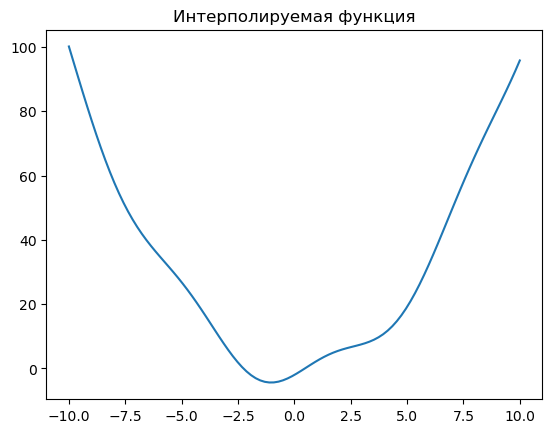

In [4]:
xarr = np.linspace(cfg['params']['a'],
                        cfg['params']['b'],
                        cfg['params']['m'])
plt.plot(xarr, fn(xarr))
plt.title(f'Интерполируемая функция')

## По $m$ равноотстоящим узлам

In [5]:
class linear_spline():
    def __init__(self, a, b, m, node_type: str='equal') -> None:
        self.a = a # leftmost point of the interval
        self.b = b # rightmost point of the interval
        self.m = m # num of nodes
        self.n = self.m - 1 # num of cubic splines
        assert node_type in ['optimal', 'equal'], 'Incorrect node type. Choose from [optimal, equal]'
        self.node_type = node_type
        self.x = self.get_nodes()
        self.coeffs = self.get_coeffs()

    def get_nodes(self):
        # choose interpolation interval
        if self.node_type == 'optimal':
            # optimal chebyshev nodes
            interval = sorted([0.5 * ((self.b - self.a) * np.cos(((2*i+1)*np.pi) / (2*(self.m + 1))) + (self.b + self.a)) for i in range(self.m)])
        elif self.node_type == 'equal':
            # equally-spaced nodes
            interval = np.linspace(self.a, self.b, self.m) 
        return interval

    def get_coeffs(self):
        n = self.n
        A = np.zeros((2*n, 2*n))
        C = np.zeros(2*n)

        # создаем матрицу системы
        A, C = self.make_system(A, C)

        # Решаем относительно b
        B = np.linalg.solve(A, C)
        ai = B[:n]
        bi = B[n:2*n]
        
        return ai, bi
        
    def make_system(self, A, C):
        x = self.x
        n = self.n
        for i in range(n):
            A[i, i] = x[i]
            A[i, n+i] = 1

            # Строки [n, 2n-1]
            A[n+i, i] = x[i+1]
            A[n+i, n+i] = 1

            C[i] = fn(x[i])
            C[n+i] = fn(x[i+1])

        # В последней строке задаем a_1 = 1    
        A[2*n-1, 0] = 1
        return A, C

    def __call__(self, arg):
        assert (arg >= self.x[0]) and (arg <= self.x[-1]),\
            f'Argument ({arg}) out of interval bounds [{self.x[0]:.3f}, {self.x[-1]:.3f}]!'
        
        # Вычисление значения от кубического сплайна    
        ai, bi = self.coeffs

        # Find the index where arg would fit in the array x
        idx = np.searchsorted(self.x, arg) - 1
        
        # Ensure idx is within bounds
        idx = min(max(idx, 0), len(self.x) - 2)

        res = ai[idx]*arg + bi[idx]
        return res

    def plot_spline(self):   
        ai, bi = self.coeffs
        for k in range(self.n):
            xspline = np.linspace(self.x[k], self.x[k+1])
            yspline = ai[k]*xspline + bi[k]
            plt.plot(xspline, yspline, '-', linewidth=4)

        plt.plot(xarr, fn(xarr), color='black', linestyle='--', label='Ground truth')
        plt.xlabel('x')
        plt.ylabel('y')
        if self.node_type == 'equal':
            plt.title('$S_{1,0}^m$ по равноотстоящим узлам для $f(x)$')
        else:
            plt.title('$S_{1,0}^m$ по узлам Чебышева для $f(x)$')
        plt.legend()
        plt.show()

In [6]:
spline = linear_spline(-10,10,6)

In [7]:
spline(10)

112.08852116913295

## Изобразим $S_{1,0}^m$

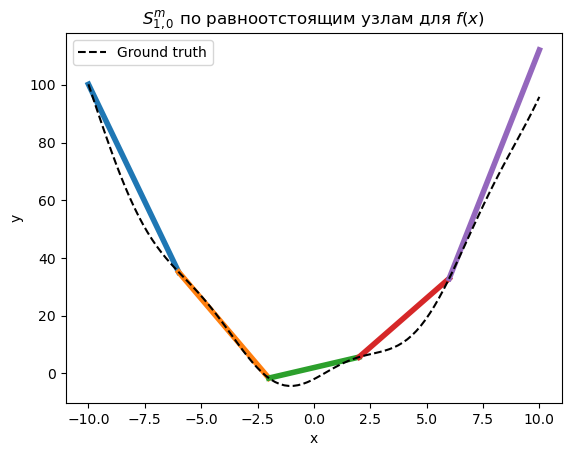

In [8]:
spline.plot_spline()

## Оптимальные узлы Чебышева 
$$x_i = 0.5 \left((b-a)\cos\dfrac{(2i+1)\pi}{2(n+1)} + (b+a)\right),\; i\in \overline{0,n}$$

## Изобразим $S_{1,0}^{m_{opt}}$

In [9]:
opt_spline = linear_spline(a=-10, b=10, m=6, node_type='optimal')

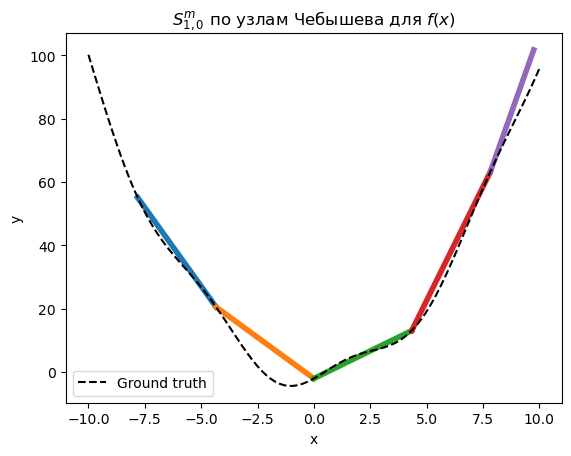

In [10]:
opt_spline.plot_spline()

## Найдем максимальные отклонения $RS_{1,0}^n, RS_{1,0}^{n_{opt}}$

In [11]:
# количество k точек разбиения интервала интерполирования, в которых определяются отклонения
k = cfg['params']['k']
max_nodes = cfg['params']['max_nodes']
a = cfg['params']['a']
b = cfg['params']['b']

In [12]:
def get_deviations(a, b, k, max_nodes):
    # mds = maximum_difference_segment
    mds = np.linspace(a, b, k)

    # значения точной функции в точках x0, x1, ..., xm; m >> n
    func_mds = [fn(i) for i in mds]

    spline_mds, optimal_spline_mds = [], []
    r1, r2 = [], []
    nodes = []
    for n_nodes in range(3, max_nodes + 1):
        spline_mds, optimal_spline_mds = [], []

        # initialize splines
        spline = linear_spline(a, b, n_nodes)
        opt_spline = linear_spline(a, b, n_nodes, 'optimal')

        # Ищем отклонения     
        for point in mds:
            # значения сплайна S_{1,0}^n в точках x0, x1, ..., xk; k >> n  
            spline_mds.append(spline(point))

            # значения сплайна S_{1,0}^{n_opt} в точках x0, x1, ..., xk; k >> n        
            point = max(opt_spline.x[0], min(opt_spline.x[-1], point))
            optimal_spline_mds.append(opt_spline(point))    

        # Отклонения
        RSn_max = max(np.abs(np.array(func_mds) - np.array(spline_mds)))
        RSn_opt_max = max([np.abs(func_mds[j] - optimal_spline_mds[j]) for j in range(len(mds))])
        
        r1.append(RSn_max)
        r2.append(RSn_opt_max)
        nodes.append(n_nodes)

    return r1, r2, nodes

In [13]:
r1, r2, nodes = get_deviations(a, b, k, max_nodes)

In [14]:
df = pd.DataFrame({
    'num of nodes': nodes,
    'RSn_max': r1,
    'RSn_opt_max': r2,
})
df

,num of nodes,RSn_max,RSn_opt_max
0,3,31.577551,84.999983
1,4,15.929343,66.049636
2,5,14.668077,55.011530
3,6,16.264606,45.047494
4,7,17.768473,36.624853
5,8,18.965166,29.944858
6,9,19.871234,24.755961
7,10,20.551792,20.723383


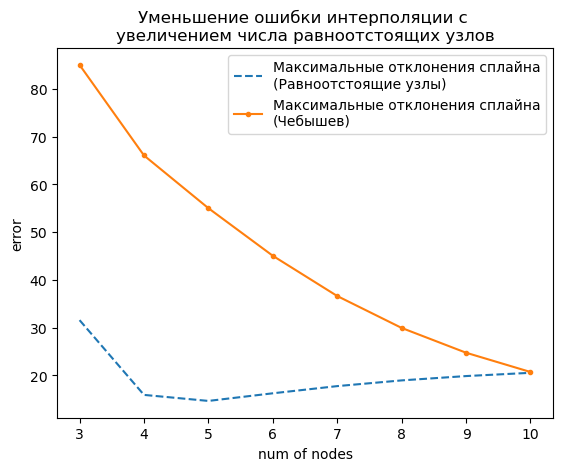

In [15]:
plt.plot(df['num of nodes'], df['RSn_max'], '--', label='Максимальные отклонения сплайна\n(Равноотстоящие узлы)')
plt.plot(df['num of nodes'], df['RSn_opt_max'], '.-', label='Максимальные отклонения сплайна\n(Чебышев)')
plt.title(f'Уменьшение ошибки интерполяции с \nувеличением числа равноотстоящих узлов')
plt.xlabel(f'num of nodes')
plt.ylabel(f'error')
plt.legend()
plt.show()